# MazeDrone with TF Agents - 08 Continue Training: Stuck Improvement keeping negative rewards for crashing

This notebook aims to develop a flow to continue trainig from the last checkpoint, performing an extensive training test, in which we use three different combinations of rewards and register the results in log files. This time, deviating from last notebook, we will keep negative rewards for crashing, as the lack of it allowed this habit to emerge again. 

The combinations are:
- Positive and negative reward, but negative is smaller (-5, -6, 10, -1)
- Positive and negative reward are the same (-5, -10, 10, -1)
- Positive and negative, but negative is bigger (-5, -15, 10, -1)

There will be 10 runs of each. The final result for each combination will be the average. The goal here is to have a solid result to compare aproaches. 

### Setup

In [11]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from __future__ import absolute_import, division, print_function



import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

### Hyperparameters

In [12]:
num_iterations = 3_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

# Agent fully connected layer params 
fc_layer_params = (200,) 

rewards = []
rewards.append({
    'destroyed': -5.,
    'stuck': - 6.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -5.,
    'stuck': -10.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -5.,
    'stuck': -15.,
    'reached': 10.,
    'standard': -1.
})

### Environment

In [13]:
sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

In [14]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 1.       ,  0.       ,  1.       ,  0.       ,  1.4142135,
       -2.3561945], dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [15]:
train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

## Loading Trained Agent

In [16]:
from resources import build_agent, TrainingSession



# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env)
agent.initialize()

# GENERATE TRAINING SESSION
session = TrainingSession(env_name, rewards[0], agent, collect_steps_per_iteration, 
                        1, eval_interval, replay_buffer_max_length, num_eval_episodes)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, _, replay_buffer = session.train()

# CLEAR MEMORY
del(session)



print("============================================================== After first training:")

print(agent.train_step_counter)

checkpoint_dir = './checkpoint/phase-1-crash'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=agent.train_step_counter
)

print(agent.train_step_counter)


train_checkpointer.initialize_or_restore()
    
print(agent.train_step_counter)

Rewards Updated: {'destroyed': -5.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -5.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Rewards: {'destroyed': -5.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
============================================================== After first training:
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>


In [17]:
print(agent.train_step_counter)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>


In [18]:
train_checkpointer.initialize_or_restore()
print(agent.train_step_counter)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>


In [19]:
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=agent.train_step_counter
)

In [20]:
print(agent.train_step_counter)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>


## Training Loop

In [21]:
from resources import build_agent, TrainingSession
import pandas as pd
import gc

for combination in range(len(rewards)):

    for run in range(10):
        print('Combination', combination + 1, ' | Run', run + 1)
        train_checkpointer = common.Checkpointer(
            ckpt_dir=checkpoint_dir,
            max_to_keep=1,
            agent=agent,
            policy=agent.policy,
            replay_buffer=replay_buffer,
            global_step=agent.train_step_counter
        )
        print(agent.train_step_counter)

        # CREATING/RESETING THE AGENT
        #agent = build_agent(fc_layer_params, env, learning_rate, train_env)
        #agent.initialize()

        # GENERATE TRAINING SESSION
        session = TrainingSession(env_name, rewards[combination], agent, collect_steps_per_iteration, 
                                num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes)
        
        # TRAINING
        step_log, returns, finished, crashed, stucked, steped, log_loss, _ = session.train()

        # LOGGING
        df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})
        df_log.to_csv(f"logs/02-stuck-improving/08_comb-{combination+1}-run-{run+1}.csv", index=None, header=True)

        # CLEAR MEMORY
        #del(agent)
        del(session)
        del(df_log)
        gc.collect()


Combination 1  | Run 1
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>
Rewards Updated: {'destroyed': -5.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -5.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}


Rewards: {'destroyed': -5.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
step = 3000


KeyboardInterrupt: 

## Visualization

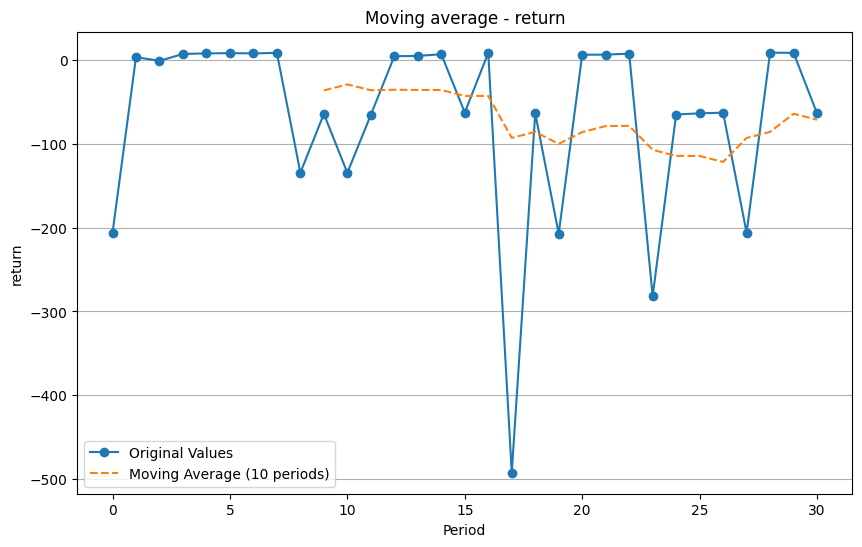

In [12]:
from resources import plot_moving_avg, plot_metric_per_iteration
plot_moving_avg('return', returns)

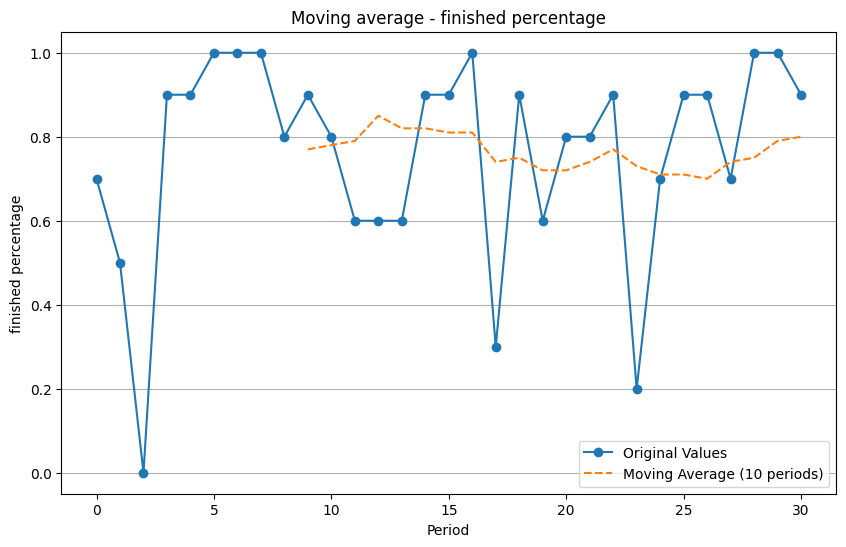

In [13]:
plot_moving_avg('finished percentage', finished)

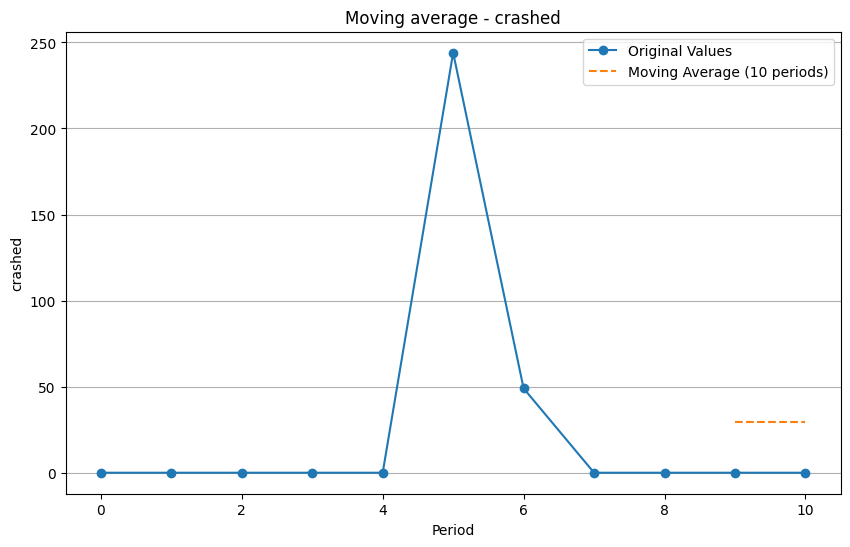

In [14]:
plot_moving_avg('crashed', crashed)

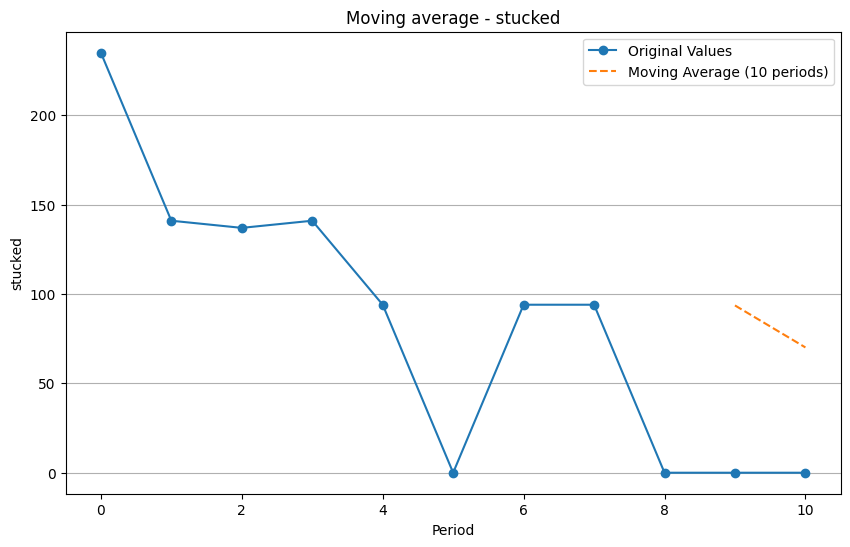

In [15]:
plot_moving_avg('stucked', stucked)

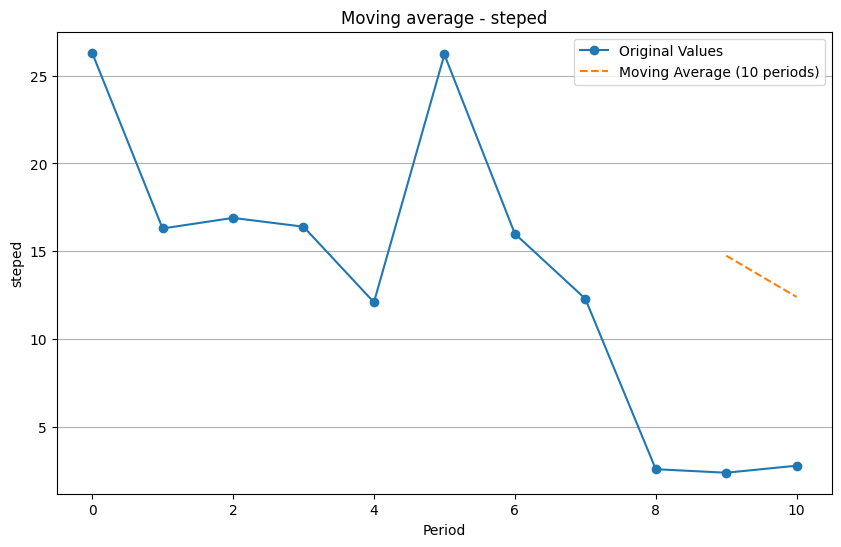

In [16]:
plot_moving_avg('steped', steped)

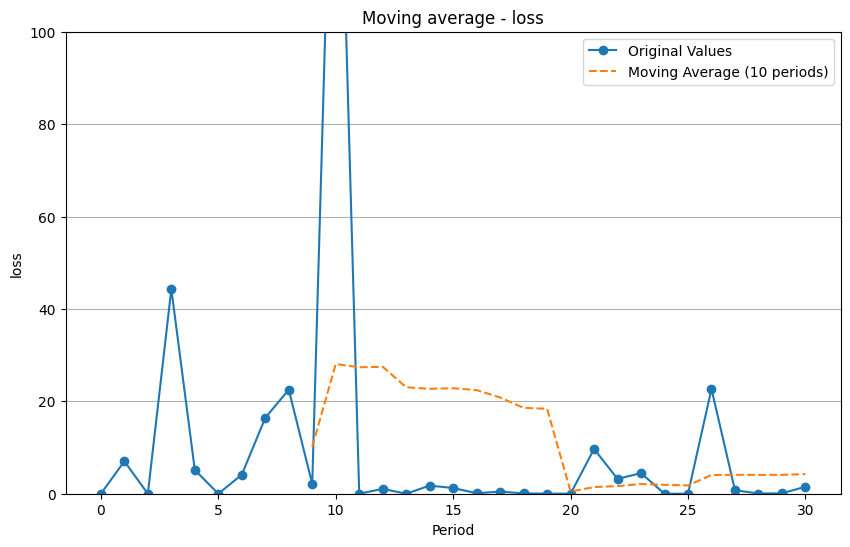

In [15]:
plot_moving_avg('loss', log_loss, ylim=True, top_lim=1_00)

In [17]:
from resources import create_policy_eval_video


# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(1)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", train_env, train_py_env)

In [18]:
print(agent.train_step_counter)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=5500>
